# Baseline

Baseline with basic augmentation like resizing


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import time

# Setup Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: NVIDIA GeForce GTX 960M


**Data Loading**

In [2]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

train_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])


data_path = '../dataset'
full_dataset = datasets.ImageFolder(root=data_path, transform=train_test_transform)

print(f"Total images: {len(full_dataset)}")
print(f"Classes: {full_dataset.classes}")
print(f"Class to index: {full_dataset.class_to_idx}")

Total images: 13902
Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic']
Class to index: {'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4}


In [3]:
# Split: 60% Train, 20% Validation, 20% Test
total_size = len(full_dataset)
train_size = int(0.6 * total_size)
val_size = int(0.2 * total_size)
test_size = total_size - train_size - val_size

torch.manual_seed(42)
train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size]
)

print(f"Train size: {len(train_dataset)}")
print(f"Validation size: {len(val_dataset)}")
print(f"Test size: {len(test_dataset)}")

BATCH_SIZE = 32
NUM_WORKERS  = 4

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS , pin_memory=True, persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True, persistent_workers=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True, persistent_workers=True)

Train size: 8341
Validation size: 2780
Test size: 2781


**Model Setup**

In [4]:
def create_resnet50(num_classes=5, pretrained=True):

    # Load ResNet-50
    if pretrained:
        weights = models.ResNet50_Weights.IMAGENET1K_V2
        model = models.resnet50(weights=weights)
    else:
        model = models.resnet50(weights=None)
    
    # ResNet-50 fc layer: (2048 -> 1000), we change to (2048 -> 5)
    num_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(num_features, num_classes)
    )
    
    return model

def create_resnet34(num_classes=5, pretrained=True):

    if pretrained:
        weights = models.ResNet34_Weights.IMAGENET1K_V1
        model = models.resnet34(weights=weights)
    else:
        model = models.resnet34(weights=None)
    
    num_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(num_features, num_classes)
    )
    
    return model

# uncomment to choose model

# model = create_resnet50(num_classes=5, pretrained=True)
model = create_resnet34(num_classes=5, pretrained=True)


model = model.to(device)
print(f"Model loaded on {device}")
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

Model loaded on cuda

Total parameters: 21,287,237
Trainable parameters: 21,287,237


**Training Setup**

In [5]:
# Hyperparameters
LEARNING_RATE = 1e-4
NUM_EPOCHS = 15
WEIGHT_DECAY = 1e-4

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer (Adam with weight decay)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Learning rate scheduler (reduce LR when validation loss plateaus)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.1, patience=3
)

**Training and Validation Functions**

In [6]:
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc


def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

**Training Loop with Early Stopping**

In [7]:
# History for plotting
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

# Best model tracking
best_val_acc = 0.0
best_model_path = '../best_model/best_resnet34_baseline.pth'
patience_counter = 0
EARLY_STOP_PATIENCE = 5

print("="*60)
print("TRAINING RESNET-34 BASELINE")
print("="*60)
start_time = time.time()

for epoch in range(NUM_EPOCHS):
    epoch_start = time.time()
    
    # Train
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    
    # Update scheduler
    scheduler.step(val_loss)
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    epoch_time = time.time() - epoch_start
    
    # Print progress
    print(f"Epoch [{epoch+1:2d}/{NUM_EPOCHS}] | "
          f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.2f}% | "
          f"Time: {epoch_time:.1f}s")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_model_path)
        print(f"  ✓ New best model saved! (Val Acc: {best_val_acc:.2f}%)")
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= EARLY_STOP_PATIENCE:
            print(f"\nEarly stopping triggered after {epoch+1} epochs")
            break

total_time = time.time() - start_time
print("="*60)
print(f"Training completed in {total_time/60:.1f} minutes")
print(f"Best Validation Accuracy: {best_val_acc:.2f}%")
print("="*60)

TRAINING RESNET-34 BASELINE
Epoch [ 1/15] | Train Loss: 0.4085, Acc: 85.87% | Val Loss: 0.1820, Acc: 94.03% | Time: 298.9s
  ✓ New best model saved! (Val Acc: 94.03%)
Epoch [ 2/15] | Train Loss: 0.1146, Acc: 96.39% | Val Loss: 0.2060, Acc: 94.24% | Time: 190.4s
  ✓ New best model saved! (Val Acc: 94.24%)
Epoch [ 3/15] | Train Loss: 0.0790, Acc: 97.40% | Val Loss: 0.2220, Acc: 93.63% | Time: 192.1s
Epoch [ 4/15] | Train Loss: 0.0652, Acc: 97.90% | Val Loss: 0.1855, Acc: 94.32% | Time: 191.8s
  ✓ New best model saved! (Val Acc: 94.32%)
Epoch [ 5/15] | Train Loss: 0.0419, Acc: 98.75% | Val Loss: 0.1765, Acc: 94.53% | Time: 193.0s
  ✓ New best model saved! (Val Acc: 94.53%)
Epoch [ 6/15] | Train Loss: 0.0301, Acc: 99.08% | Val Loss: 0.1933, Acc: 94.64% | Time: 187.8s
  ✓ New best model saved! (Val Acc: 94.64%)
Epoch [ 7/15] | Train Loss: 0.0356, Acc: 98.86% | Val Loss: 0.1822, Acc: 94.93% | Time: 182.7s
  ✓ New best model saved! (Val Acc: 94.93%)
Epoch [ 8/15] | Train Loss: 0.0542, Acc: 98

**Plot Training History**

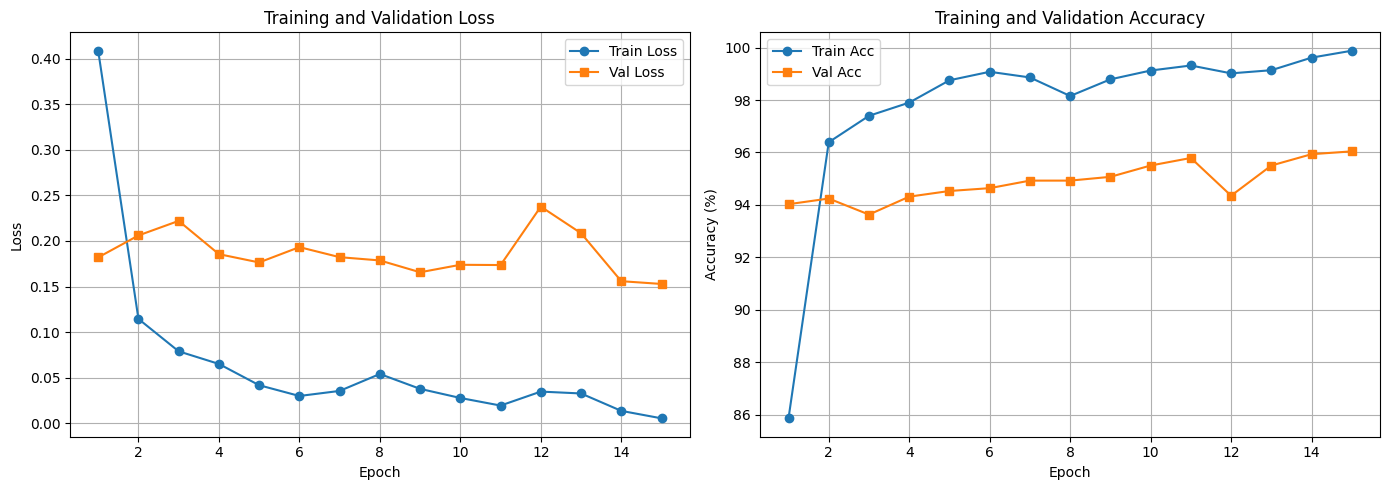

Training curves saved to '../plots/baseline_training_curves.png'


In [8]:
epochs = np.arange(1, len(history['train_loss']) + 1)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
axes[0].plot(epochs, history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(epochs, history['val_loss'], label='Val Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True)

# Accuracy plot
axes[1].plot(epochs, history['train_acc'], label='Train Acc', marker='o')
axes[1].plot(epochs, history['val_acc'], label='Val Acc', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig('../plots/baseline_training_curves.png', dpi=150)
plt.show()

print("Training curves saved to '../plots/baseline_training_curves.png'")

**Evaluate on Test Set**

In [9]:
# Load best model
model.load_state_dict(torch.load(best_model_path))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Calculate test accuracy
test_accuracy = 100 * np.sum(all_preds == all_labels) / len(all_labels)
print(f"\n{'='*60}")
print(f"TEST SET RESULTS - RESNET-34 BASELINE")
print(f"{'='*60}")
print(f"Test Accuracy: {test_accuracy:.2f}%")
print(f"{'='*60}")


TEST SET RESULTS - RESNET-34 BASELINE
Test Accuracy: 96.12%


In [10]:
# Classification Report
class_names = full_dataset.classes
print("\nClassification Report:")
print("-"*60)
print(classification_report(all_labels, all_preds, target_names=class_names))


Classification Report:
------------------------------------------------------------
              precision    recall  f1-score   support

   cardboard       0.95      0.97      0.96       583
       glass       0.97      0.97      0.97       660
       metal       0.96      0.96      0.96       440
       paper       0.96      0.94      0.95       468
     plastic       0.97      0.95      0.96       630

    accuracy                           0.96      2781
   macro avg       0.96      0.96      0.96      2781
weighted avg       0.96      0.96      0.96      2781



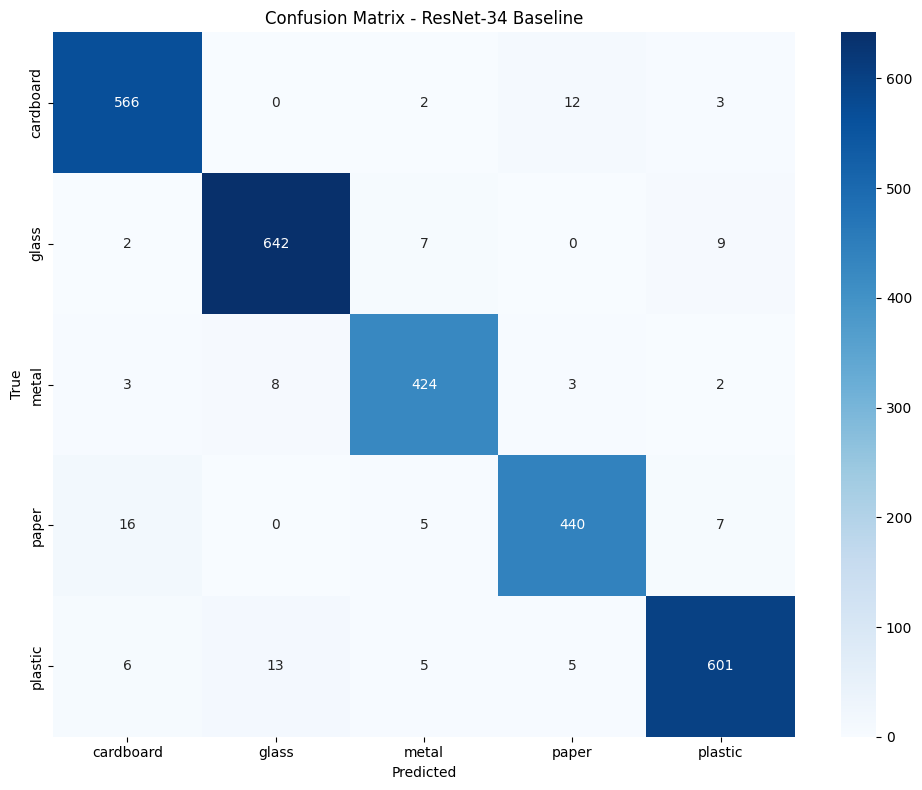

Confusion matrix saved to '../plots/baseline_confusion_matrix.png'


In [11]:
# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - ResNet-34 Baseline')
plt.tight_layout()
plt.savefig('../plots/baseline_confusion_matrix.png', dpi=150)
plt.show()

print("Confusion matrix saved to '../plots/baseline_confusion_matrix.png'")

**Save Results for Comparison**

In [12]:
# Save results dictionary for later comparison
import json

epochs_trained = len(history['train_loss']) if isinstance(history, dict) and 'train_loss' in history else None

results = {
    'model': 'ResNet34',
    'experiment': 'Baseline (No Augmentation)',
    'num_epochs_trained': epochs_trained,
    'best_val_accuracy': best_val_acc,
    'test_accuracy': test_accuracy,
    'augmentations': [
        'Resize(224)',
        'Normalize(ImageNet)'
    ]
}

with open('../results/baseline_results.json', 'w') as f:
    json.dump(results, f, indent=2)

print(f"\nResults saved to '../results/baseline_results.json'")


Results saved to '../results/baseline_results.json'
